In [51]:
import tensorflow as tf
import os
import numpy as np
import threading
from datetime import datetime
from matplotlib import pylab as plt
%matplotlib inline

In [52]:
dir=os.getcwd()
print dir
file_dir = tf.gfile.Glob(dir+'/n*')
labels= [f[-9:] for f in file_dir]
print labels

/home/sherlock/workspace/ILSVRC2015/sample_data
['n03792782', 'n04550184', 'n04552348']


In [53]:
labels_file ='imagenet_metadata.txt'
lines = tf.gfile.FastGFile(labels_file, 'r').readlines()
synset_to_human = {}
for l in lines:
    if l:
        parts = l.strip().split('\t')
        assert len(parts) == 2
        synset = parts[0]
        if synset in labels:
            human = parts[1]
            synset_to_human[synset] = human
print synset_to_human


{'n04550184': 'wardrobe, closet, press', 'n04552348': 'warplane, military plane', 'n03792782': 'mountain bike, all-terrain bike, off-roader'}


In [54]:
def _int64_feature(value):
    """Wrapper for inserting int64 features into Example proto."""
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def _float_feature(value):
    """Wrapper for inserting float features into Example proto."""
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def _bytes_feature(value):
    """Wrapper for inserting bytes features into Example proto."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def convert_2_example(filename, image_buffer, label,
                                    synset, human, 
                                    height, width):
    """Build an Example proto for an example.
    Args:
        filename: string, path to an image file, e.g., '/path/to/example.JPG'
        image_buffer: string, JPEG encoding of RGB image
        label: integer, identifier for the ground truth for the network
        synset: string, unique WordNet ID specifying the label, e.g., 'n02323233'
        human: string, human-readable label, e.g., 'red fox, Vulpes vulpes'
        height: integer, image height in pixels
        width: integer, image width in pixels
    Returns:
        Example proto
    """
    colorspace = 'RGB'
    channels = 3
    image_format = 'JPEG'
    
    example = tf.train.Example(features=tf.train.Features(feature={
      'image/height': _int64_feature(height),
      'image/width': _int64_feature(width),
      'image/colorspace': _bytes_feature(colorspace),
      'image/channels': _int64_feature(channels),
      'image/class/label': _int64_feature(label),
      'image/class/synset': _bytes_feature(synset),
      'image/class/text': _bytes_feature(human),
      'image/format': _bytes_feature(image_format),
      'image/filename': _bytes_feature(os.path.basename(filename)),
      'image/encoded': _bytes_feature(image_buffer)}))
    return example
    

In [55]:
class ImageCoder(object):
    """Helper class that provides TensorFlow image coding utilities."""
    def __init__(self):
        # Create a single Session to run all image coding calls.
        self._sess = tf.Session()
        self._image_in=tf.placeholder(dtype=tf.string)
        self._image_node = tf.image.decode_jpeg(self._image_in, channels=3)
        
    
    def decode_jpeg(self, image_data):
        image = self._sess.run(self._image_node,
                           feed_dict={self._image_in: image_data})
        assert len(image.shape) == 3
        assert image.shape[2] == 3
        return image

def process_single_image(filename,coder):
    """Process a single image file.
    """
    with tf.gfile.FastGFile(filename, 'r') as f:
        image_data = f.read()
    
        
    # Check that image converted to RGB
    image = coder.decode_jpeg(image_data)
    assert len(image.shape) == 3
    height = image.shape[0]
    width = image.shape[1]
    assert image.shape[2] == 3

    return image_data, height, width
        
    


def process_image_batch(coder,thread_index, ranges,  filenames,
                               synsets, labels, humans):
    """Process a batch of image files and write to TFRecords
    """
    num_threads = len(ranges)
    num_files_in_batch =ranges[thread_index][1]-ranges[thread_index][0]
    file_in_batch = np.linspace(ranges[thread_index][0],
                             ranges[thread_index][1]-1,
                             num_files_in_batch).astype(int)
    
   
    
    
    counter = 0
    output_file ='ImageNet_sample'+str(thread_index)
    writer = tf.python_io.TFRecordWriter(output_file)
    
    counter =0
    for f_ind in  file_in_batch:
        filename = filenames[f_ind]
        label = labels[f_ind]
        synset = synsets[f_ind]
        human = humans[f_ind]
        
        image_buffer, height, width = process_single_image(filename,coder)

        example = convert_2_example(filename, image_buffer, label,
                                    synset, human, 
                                    height, width)
        writer.write(example.SerializeToString())
        counter +=1
                       
    writer.close() 


In [56]:
def find_files(dir,synset_to_human):
    humans =[]
    filenames =[]
    synsets =[]
    labels =[]
    label = 0
    for synset,human in synset_to_human.iteritems():
        jpeg_file_path = dir+'/'+synset+'/*'
        matching_files = tf.gfile.Glob(jpeg_file_path)
        
        
        labels.extend([label] * len(matching_files))
        synsets.extend([synset] * len(matching_files))
        humans.extend([human] * len(matching_files))
        filenames.extend(matching_files)
        label += 1
     
    return filenames, synsets, humans,labels

def process_image_files(filenames, synsets, labels, humans):
    """Process and save list of images as TFRecord of Example protos.
    Args:
       filenames: list of strings; each string is a path to an image file
        synsets: list of strings; each string is a unique WordNet ID
        labels: list of integer; each integer identifies the ground truth
        humans: list of strings; each string is a human-readable label
    """
    assert len(filenames) == len(synsets)
    assert len(filenames) == len(labels)
    assert len(filenames) == len(humans)
    # Break all images into batches with a [ranges[i][0], ranges[i][1]].
    num_of_threads = 4
    spacing = np.linspace(0, len(filenames), num_of_threads).astype(np.int)
    ranges = []
    coder = ImageCoder()
    threads = []
    for i in xrange(len(spacing) - 1):
        ranges.append([spacing[i], spacing[i+1]])

    # Launch a thread for each batch.
    
    # Create a mechanism for monitoring when all threads are finished.
    coord = tf.train.Coordinator()

    # Create a generic TensorFlow-based utility for converting all image codings.
    
    threads = []
    for thread_index in xrange(len(ranges)):
        args = (coder,thread_index, ranges,  filenames,
            synsets, labels, humans)
        t = threading.Thread(target=process_image_batch, args=args)
        t.start()
        threads.append(t)

    # Wait for all the threads to terminate.
    coord.join(threads)
    print('%s: Finished writing all %d images in data set.' %
        (datetime.now(), len(filenames)))
    

In [57]:
tf.reset_default_graph()
filenames, synsets, humans,labels=find_files(dir,synset_to_human)
process_image_files(filenames, synsets, labels, humans)


2016-12-05 13:51:36.549773: Finished writing all 150 images in data set.


In [42]:
f_ind = 1
filename = filenames[f_ind]
label = labels[f_ind]
synset = synsets[f_ind]
human = humans[f_ind]
coder = ImageCoder()        
image_buffer, height, width = process_single_image(filename,coder)
image = coder.decode_jpeg(image_buffer)


In [43]:
label,synset,human

(0, 'n03792782', 'mountain bike, all-terrain bike, off-roader')

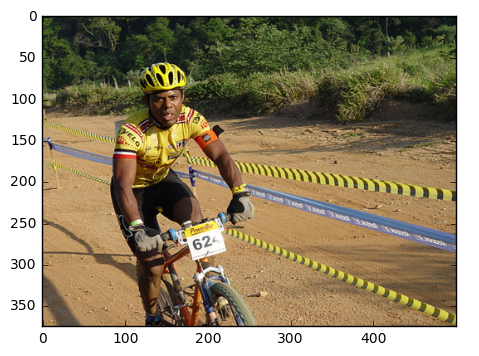

In [45]:
plt.imshow(image)